In [1]:
from tensorflow.keras import Model 
from tensorflow.keras.layers import Input
from tensorflow.keras. layers import Conv2D ,ReLU, BatchNormalization, Flatten, Dense, Reshape, Conv2DTranspose, Activation, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import os
import pickle 
import tensorflow as tf
import keras
tf.compat.v1.disable_eager_execution()



class VAE:
  """
  Deep Variational convolutional autoencoder with mirrored encoder decoder 
  """

  def __init__(self, 
               input_shape, 
               conv_filters,
               conv_kernels,
               conv_strides,
               latent_space_dim):
    self.input_shape= input_shape             #[width,height,channels]
    self.conv_filters = conv_filters          #[2,4,8] etc
    self.conv_kernels = conv_kernels          #[3,5,3] etc
    self.conv_strides = conv_strides          #[1,2,2] etc
    self.latent_space_dim = latent_space_dim  # int(2)
    self.reconstruction_loss_weight = 10000
    
    self.encoder = None 
    self.decoder = None 
    self.model = None 
    self._model_input = None

    self.num_conv_layers = len(conv_filters)
    self._shape_before_bottleneck = None 

    self._build()
  
  def summary(self):
    self.encoder.summary()
    self.decoder.summary()
    self.model.summary()
    
  def compile(self,learning_rate=0.0001):
    optimizer = Adam(learning_rate=learning_rate)
    loss = self._calculate_combined_loss
    self.model.compile(optimizer = optimizer , loss = loss, metrics = [self._calculate_reconstruction_loss,self._calculate_kl_loss])

  def train(self, x_train,batch_size , num_epochs,):
    self.model.fit(x_train,
                   x_train,
                   batch_size=batch_size,
                   epochs = num_epochs,
                   shuffle = True)
    
  def save(self, save_folder="/content/automodel"):
    self._create_folder_if_it_dosent_exist(save_folder)
    self._save_parameters(save_folder)
    self._save_weights(save_folder)

  def _create_folder_if_it_dosent_exist(self,folder):
    if not os.path.exists(folder):
      os.makedirs(folder)
  
  def _save_parameters(self, save_folder):
    parameters = [self.input_shape, self.conv_filters ,self.conv_kernels, 
    self.conv_strides,self.latent_space_dim]
    save_path = os.path.join(save_folder + "parameters.pkl")
    with open(save_path,"wb") as f:
      pickle.dump(parameters, f)

  def _save_weights(self,save_folder):
    save_path = os.path.join(save_folder + "weights.h5")
    self.model.save_weights(save_path)

  def reconstruct(self,images):
    latent_representations = self.encoder.predict(images)
    reconstructed_images = self.decoder.predict(latent_representations)
    return reconstructed_images,latent_representations
  
  @classmethod
  def load(cls, save_folder = "/content/automodel"):
    parameters_path = os.path.join(save_folder + "parameters.pkl")
    weights_path = os.path.join(save_folder + "weights.h5")
    with open(parameters_path ,"rb") as f:
      parameters = pickle.load(f)
    auto =VAE(*parameters)
    auto.load_weights(weights_path)
    return auto
  
  def _calculate_combined_loss(self,y_target,y_predicted):
    reconstruction_loss = self._calculate_reconstruction_loss(y_target,y_predicted)
    kl_loss =self._calculate_kl_loss(y_target,y_predicted)
    #combined_loss = K.mean(reconstruction_loss + kl_loss)
    combined_loss = self.reconstruction_loss_weight*reconstruction_loss + kl_loss 
    return combined_loss

  def _calculate_reconstruction_loss(self, y_target,y_predicted):
    error= y_target - y_predicted
    #reconstructed_loss = K.mean(K.square(error), axis=[1,2,3])
    reconstructed_loss = keras.metrics.binary_crossentropy(K.flatten(y_target),K.flatten(y_predicted))
    return reconstructed_loss
  
  def _calculate_kl_loss(self,y_target,y_predicted):
    """ closed form kollback-liebler divergance : used to find distance between two distribution """
    kl_loss = -0.5 * K.sum(1 + self.log_variance - K.square(self.mu)- K.exp(self.log_variance), axis=1)
    return kl_loss

  def load_weights(self,weights_path):
    self.model.load_weights(weights_path)

  def _build(self):
    self._build_encoder()
    self._build_decoder()
    self._build_autoencoder()
 
 #Build auto encoder 
  def _build_autoencoder(self):
    model_input = self._model_input 
    model_output = self.decoder(self.encoder(model_input))
    self.model = Model(model_input, model_output, name = "autoencoder")

 # Decoder Part 
  def _build_decoder(self):
    decoder_input = self._add_decoder_input()
    dense_layer = self._add_dense_layer(decoder_input)
    reshape_layer = self._add_reshape_layer(dense_layer)
    conv_transpose_layer = self._add_conv_transpose_layers(reshape_layer)
    decoder_output = self._add_decoder_output(conv_transpose_layer)
    self.decoder = Model(decoder_input, decoder_output, name="decoder")

  def _add_decoder_input(self):
    return Input(shape=self.latent_space_dim, name = "decoder_input")

  def _add_dense_layer(self,decoder_input):
    num_neurons = np.prod(self._shape_before_bottleneck)       #bottleneck_dim = [4,4,32] => 4*4*32 == 512 <= num_neurons 
    return Dense(num_neurons , name = "decoder_dense")(decoder_input)
    

  def _add_reshape_layer(self, dense_layer): 
    return Reshape(self._shape_before_bottleneck)(dense_layer)
    
  def _add_conv_transpose_layers(self, x):
    """ loop through all conv layers in reverse order and stop at the first layer"""
    """ last layer is special layer"""
    for layer_index in reversed(range(1,self.num_conv_layers)):
        x = self._add_conv_transpose_layer(layer_index, x)
    return x

  def _add_conv_transpose_layer(self,layer_index, x):
    layer_num = self.num_conv_layers - layer_index
    conv_transpose_layer = Conv2DTranspose(
        filters = self.conv_filters[layer_index],
        kernel_size = self.conv_kernels[layer_index],
        strides = self.conv_strides[layer_index],
        padding = "same",
        name = f"decoder_conv_transpose_layer{layer_num}"

    )
    x = conv_transpose_layer(x)
    x = ReLU(name=f"decoder_relu{layer_num}")(x)
    x = BatchNormalization(name=f"decoder_BN{layer_num}")(x)
    return x 
  
  def _add_decoder_output(self,x):
    conv_transpose_layer = Conv2DTranspose(
        filters = self.input_shape[-1],
        kernel_size = self.conv_kernels[0],
        strides = self.conv_strides[0],
        padding = "same",
        name = f"decoder_conv_transpose_layer{self.num_conv_layers}"

    )
    x = conv_transpose_layer(x)
    return Activation("sigmoid",name="sigmoid")(x)

# Encoder part
  def _build_encoder(self):
    encoder_input = self._add_encoder_input()
    conv_layers = self._add_conv_layers(encoder_input)
    bottleneck = self._add_bottleneck(conv_layers)
    self._model_input = encoder_input
    self.encoder = Model(encoder_input, bottleneck , name ="encoder")     #keras.Model()
  
  def _add_encoder_input(self):
    return Input(shape = self.input_shape, name = "encoder_input")        #keras.layers.Input()
  
  def _add_conv_layers(self, encoder_input):
    """Creates all convolutional blocks in encoder"""
    x = encoder_input 
    for layer_index in range(self.num_conv_layers):
      x = self._add_conv_layer(layer_index, x) 
    return x

  def _add_conv_layer(self, layer_index, x):
    """Adds a convolutional block to a graph of layers consisting of
     conv2d + relu acti + batch_norm"""
    layer_number = layer_index +1
    conv_layer = Conv2D(
        filters = self.conv_filters[layer_index],
        kernel_size = self.conv_kernels[layer_index],
        strides = self.conv_strides[layer_index],
        padding = "same",
        name = f"encoder_conv_layer_{layer_number}"
    )
    x = conv_layer(x)
    x = ReLU(name=f"encoder_relu_{layer_number}")(x)
    x = BatchNormalization(name = f"encoder_batchnorm_{layer_number}")(x)
    return x
  
  def _add_bottleneck(self,x):
    """Flatten data and add bottleneck with Gaussian Sampling (Dense layer)"""
    self._shape_before_bottleneck = K.int_shape(x)[1:]  #[batch_size, width, height, channels]: [2,7,7,1]
    x = Flatten()(x)
    self.mu =Dense(self.latent_space_dim, name="mean_mu")(x)
    self.log_variance = Dense(self.latent_space_dim, name="log_variance")(x)
    
    def sample_point_from_norm_distro(args):
      mu, log_variance = args
      epsilon = K.random_normal(shape=K.shape(self.mu), mean =0.,
                                stddev = 1.)
      sigma = K.exp(log_variance / 2)
      sampled_point = mu + sigma*epsilon 
      return sampled_point

    x = Lambda(sample_point_from_norm_distro,
               name = "encoder_output")([self.mu , self.log_variance])
    return x 
  
  

In [ ]:
if __name__ =="__main__":
  auto = VAE(
               input_shape = (28,28,1), 
               conv_filters = (32,64,64,64),
               conv_kernels=(3,3,3,3),
               conv_strides=(1,2,2,1),
               latent_space_dim = 2
               )
  auto.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder_conv_layer_1 (Conv2D)   (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_relu_1 (ReLU)           (None, 28, 28, 32)   0           encoder_conv_layer_1[0][0]       
__________________________________________________________________________________________________
encoder_batchnorm_1 (BatchNorma (None, 28, 28, 32)   128         encoder_relu_1[0][0]             
____________________________________________________________________________________________

In [ ]:
from tensorflow.keras.datasets import mnist



def load_mnist():
  (x_train,y_train),(x_test,y_test) = mnist.load_data()
  x_train = x_train.astype("float32")/255         #normalisation 
  x_train = x_train.reshape(x_train.shape + (1,))   #add extra dim c
  x_test = x_test.astype("float32")/255         
  x_test = x_test.reshape(x_test.shape + (1,))  
  return x_train, x_test, y_train, y_test

def train(x_train, learning_rate,batch_size,num_epochs):
   auto = VAE(
               input_shape = (28,28,1), 
               conv_filters = (32,64,64,64),
               conv_kernels=(3,3,3,3),
               conv_strides=(1,2,2,1),
               latent_space_dim = 2
               )
   auto.summary()
   auto.compile(learning_rate)
   auto.train(x_train,batch_size,num_epochs)
   return auto 

def retrain(save_path, x_train,learning_rate, batch_size,num_epochs):
   auto = VAE.load(save_path)
   auto.summary()
   auto.compile(learning_rate)
   auto.train(x_train,batch_size,num_epochs)
   auto.save(save_path)
   return auto 

In [ ]:
LEARN_RATE,BATCH_SIZE,EPOCHS = 0.0005 ,32 ,100

In [ ]:
x_train,_,_,_  = load_mnist()
autoencoder = train(x_train[:10000], LEARN_RATE,BATCH_SIZE,EPOCHS)
autoencoder.save("/content/drive/MyDrive/Models/VAE_model")

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder_conv_layer_1 (Conv2D)   (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_relu_1 (ReLU)           (None, 28, 28, 32)   0           encoder_conv_layer_1[0][0]       
__________________________________________________________________________________________________
encoder_batchnorm_1 (BatchNorma (None, 28, 28, 32)   128         encoder_relu_1[0][0]             
____________________________________________________________________________________________

In [ ]:
auto = retrain("/content/drive/MyDrive/Models/VAE_model",x_train,LEARN_RATE,BATCH_SIZE,100)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder_conv_layer_1 (Conv2D)   (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_relu_1 (ReLU)           (None, 28, 28, 32)   0           encoder_conv_layer_1[0][0]       
__________________________________________________________________________________________________
encoder_batchnorm_1 (BatchNorma (None, 28, 28, 32)   128         encoder_relu_1[0][0]             
____________________________________________________________________________________________

In [ ]:
auto.save("/content/VAE_model_3/")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def select_image(images, labels, num_images=10):
  sample_images_index = np.random.choice(range(len(images)),num_images)
  sample_images = images[sample_images_index]
  sample_labels = labels[sample_images_index]
  return sample_images, sample_labels

def plot_reconstructed_images(images, reconstructed_images):
  fig = plt.figure(figsize = (15,3))
  num_images= len(images)
  for i,(image, reconstructed_image ) in enumerate(zip(images,reconstructed_images)):
    image = image.squeeze()
    ax = fig.add_subplot(2, num_images, i+1)
    ax.axis("off")
    ax.imshow(image, cmap= "gray_r")
    reconstructed_image = reconstructed_image.squeeze()
    ax = fig.add_subplot(2, num_images, i+num_images+1)
    ax.axis("off")
    ax.imshow(reconstructed_image, cmap= "gray_r")


def plot_images_encoded_in_latent_space(latent_representations, sample_labels):
  plt.figure(figsize=(10,10))
  plt.scatter(latent_representations[:,0],
              latent_representations[:,1],
              cmap="gist_rainbow",
              c=sample_labels,
              alpha =0.5,
              verbose=True,
              s=20)
  plt.colorbar()
  plt.show()

In [ ]:
auto2 = VAE.load("/content/drive/MyDrive/Models/VAE_model")

In [ ]:
x_train,x_test,y_train,y_test  = load_mnist()
num_samples = 10
sample_images, sample_labels = select_image(x_train, y_train, num_images=num_samples)


11493376/11490434 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


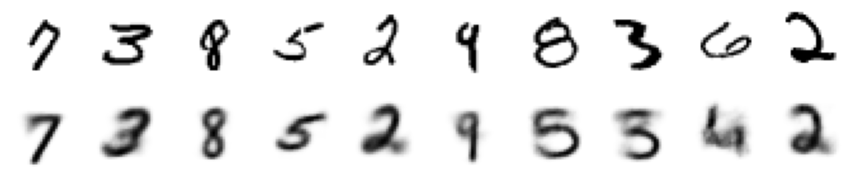

In [ ]:
reconstructed_images,latent_reps = auto2.reconstruct(sample_images)
plot_reconstructed_images(sample_images,reconstructed_images)

In [ ]:
plot_images_encoded_in_latent_space(latent_reps, sample_images)